In [25]:
from experiments.regression_0.analysis import Reader
from ga_regression import *
from matplotlib import pyplot as plt
import PIL
import matplotlib as mpl
import pyvista as pv
from scipy.stats import pearsonr

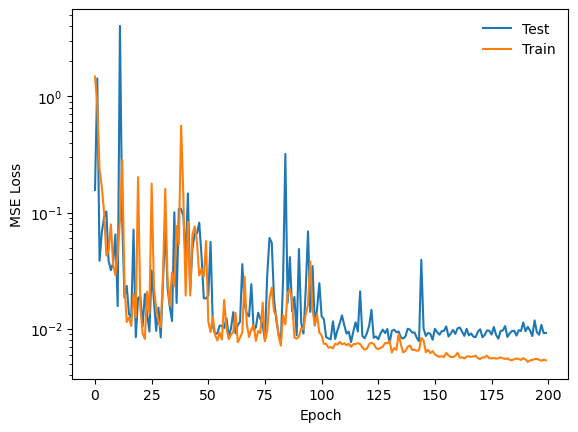

In [118]:
folder = r"D:\resynth\run_48_49\resynth_everything3\2025-07-10-21-40-08"
folder = Path(folder)
r = Reader(folder)
meta = r.metadata()
opts = meta['opts']
epoch, ltest = r.scalar('loss/test')
epoch, ltrain = r.scalar('loss/train')
plt.plot(epoch, ltest, label='Test')
plt.plot(epoch, ltrain, label='Train')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend(frameon=False);

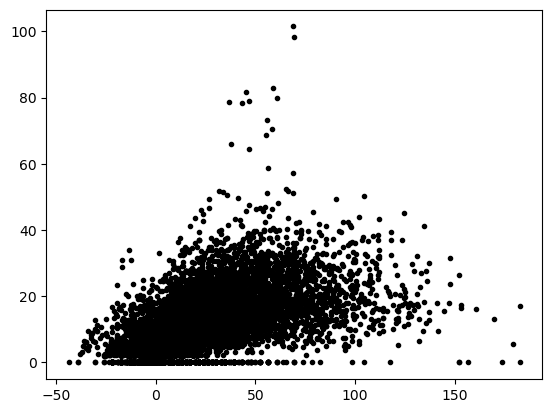

In [153]:
df = pd.read_hdf(r"D:\resynth\run_48_49\run00048_exported.hdf", key='responses')  # .query('channel == 14')
plt.plot(df.response, df.stddev_response, 'k.')

In [259]:
Path('foo.bar').with_suffix('.x')

WindowsPath('foo.x')

In [255]:
dfi = df[df.channel.isin(opts.channel)]
dfi = df.set_index(['scene', 'channel']).loc[dataset.df.scene.values] # .unstack('channel')
# dfi.xs(2, level='channel', axis=1)
# dfi.loc[slice(None), opts.channel]
# dfi
r_raw = dfi.response.unstack('channel').loc[:, list(opts.channel)]
r_min, r_max = r_raw.min(axis=0), r_raw.max(axis=0)
r_norm = (r_raw - r_min) / (r_max - r_min)
r_norm = r_norm.stack('channel')

sd_raw = dfi.stddev_response.unstack('channel').loc[:, list(opts.channel)]
sd_norm = sd_raw / (r_max - r_min)
sd_norm = sd_norm.stack('channel')

n_reps = dfi.n_reps.unstack('channel').loc[:, list(opts.channel)].stack('channel')

# Vtotal = 1 / len(r_norm) * ((r_norm - r_norm.mean()) ** 2).sum()
Vtotal = np.var(obs, ddof=1)
Vnoise = (sd_norm ** 2).mean()
# r = pearsonr(obs.reshape(-1), preds.reshape(-1)).statistic
r = np.corrcoef(obs.reshape(-1), preds.reshape(-1))[0, 1]
Vexplainable = Vtotal - Vnoise / n_reps.mean()
Vmodelerr = ((obs - preds) ** 2).mean()
fev = 1 - Vmodelerr / Vexplainable

print(f'{Vtotal=}')
print(f'{Vnoise=}')
print(f'Vnoise / Vtotal = {Vnoise / Vtotal}')
print(f'{Vexplainable=}')
print(f'{Vmodelerr=}')
print(f'{r=}')
print(f'{fev=}')

Vtotal=0.035300384014247094
Vnoise=0.007385469545840811
Vnoise / Vtotal = 0.2092178244536962
Vexplainable=0.03347345207396016
Vmodelerr=0.04972068704569699
r=0.4055765113008868
fev=-0.48537673783505464


0.20921782445369622

In [257]:
np.sqrt(-fev)

0.6966898433557466

In [ ]:
(dfi.stddev_response ** 2).sum()

In [ ]:
df.stddev_response * df.

In [158]:
scenes, responses, op_cache_dir, weights, fit_fns = GaDataset.load_data(
    data_file=opts.data_file,
    k_eig=opts.k_eig,
    channel=opts.channel,
    file_mode=opts.mesh_file_mode,
    norm_verts=opts.norm_verts,
    spike_window=opts.spike_window,
    precalc_ops=True,
    weight_error=opts.weight_error,
)

Pre-calculating operators


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:34<00:00, 30.16it/s]


In [159]:
responses

array([[0.00826446, 0.1443299 , 0.02222222, ..., 0.14285714, 0.04761905,
        0.        ],
       [0.04132231, 0.25773196, 0.13333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12371134, 0.01111111, ..., 0.04761905, 0.        ,
        0.        ],
       ...,
       [0.57024793, 0.57731959, 0.43333333, ..., 0.61904762, 0.14285714,
        0.06666667],
       [0.30165289, 0.28350515, 0.2       , ..., 0.26190476, 0.0952381 ,
        0.03333333],
       [0.47107438, 0.49484536, 0.58888889, ..., 0.38095238, 0.0952381 ,
        0.06666667]])

In [4]:
dataset = GaDataset(
    df=scenes,
    responses=responses,
    root_dir=opts.data_file.parent,
    k_eig=opts.k_eig,
    op_cache_dir=op_cache_dir,
    normalize=opts.norm_verts,
    file_mode=opts.mesh_file_mode,
    weights=weights,
)

train_test_scenes = (meta['train_scenes'], meta['test_scenes'])
train_dataset, test_dataset = opts.load_datasets(precalc_ops=True, train_test_scenes=train_test_scenes)

expt = opts.experiment(train_dataset=train_dataset, test_dataset=test_dataset)
expt.model.load_state_dict(torch.load(opts.model_file))

Pre-calculating operators


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:06<00:00, 160.19it/s]


<All keys matched successfully>

In [20]:
expt.model.outputs_at = 'global_mean'
loader = DataLoader(dataset, batch_size=None, shuffle=False)
obs, preds = expt.predict(loader, agg_fn=np.stack)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:24<00:00, 42.95it/s]


In [17]:
expt.model.outputs_at = 'global_mean'
train_loader = DataLoader(expt.train_dataset, batch_size=None, shuffle=True)
test_loader = DataLoader(expt.test_dataset, batch_size=None)
    
obs_train, preds_train = expt.predict(train_loader)
obs_test, preds_test = expt.predict(test_loader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 43.76it/s]


Text(0, 0.5, 'Predicted response')

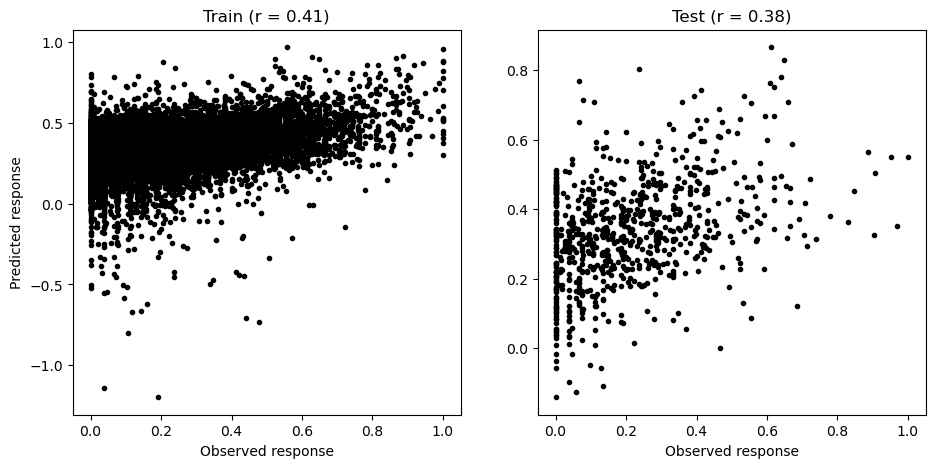

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
responses = (obs_train, preds_train), (obs_test, preds_test)
for ax, (r_obs, r_preds), ttl in zip(axs, responses, ('Train', 'Test')):
    ax.plot(r_obs, r_preds, 'k.')
    stats = pearsonr(r_obs, r_preds)
    ax.set_title(f'{ttl} (r = {stats.statistic:.2f})')
    ax.set_xlabel('Observed response')

    
axs[0].set_ylabel('Predicted response')

In [56]:
def load_mesh_img(stim_idx, upsample=False, background_color=None):
    r = scenes.iloc[stim_idx]
    render_img = PIL.Image.open(opts.data_dir / r.render)
    m_full0 = pv.read(opts.data_dir / r.remeshed)
    m_simp0 = pv.read(opts.data_dir / r.simplified)
    
    tr = np.linalg.inv(m_full0.field_data['to_cam_transform'])
    m_simp1 = m_simp0.transform(tr, inplace=False)
    m_full1 = m_full0.transform(tr, inplace=False)
    
    expt.model.outputs_at = 'vertices'
    data = verts, faces, _frames, mass, *_ = dataset[stim_idx]
    _, vert_weights, _ = expt.load_item(data)
    m_simp1.point_data['x'] = vert_weights[:, ch_idx].cpu().detach().numpy()

    if upsample:
        mesh = m_full1.interpolate(m_simp1)
    else:
        mesh = m_simp1
    
    p = pv.Plotter(window_size=(1024, 1024))
    if background_color:
        p.background_color=background_color
    p.add_mesh(mesh, scalars='x', show_scalar_bar=False)
    p.camera.position = m_full0.field_data['cam_pos']
    p.camera.focal_point = m_full0.field_data['cam_focal_point']
    p.camera.up = m_full0.field_data['cam_view_up']
    mesh_img = PIL.Image.fromarray(p.screenshot())

    return p, mesh, render_img, mesh_img

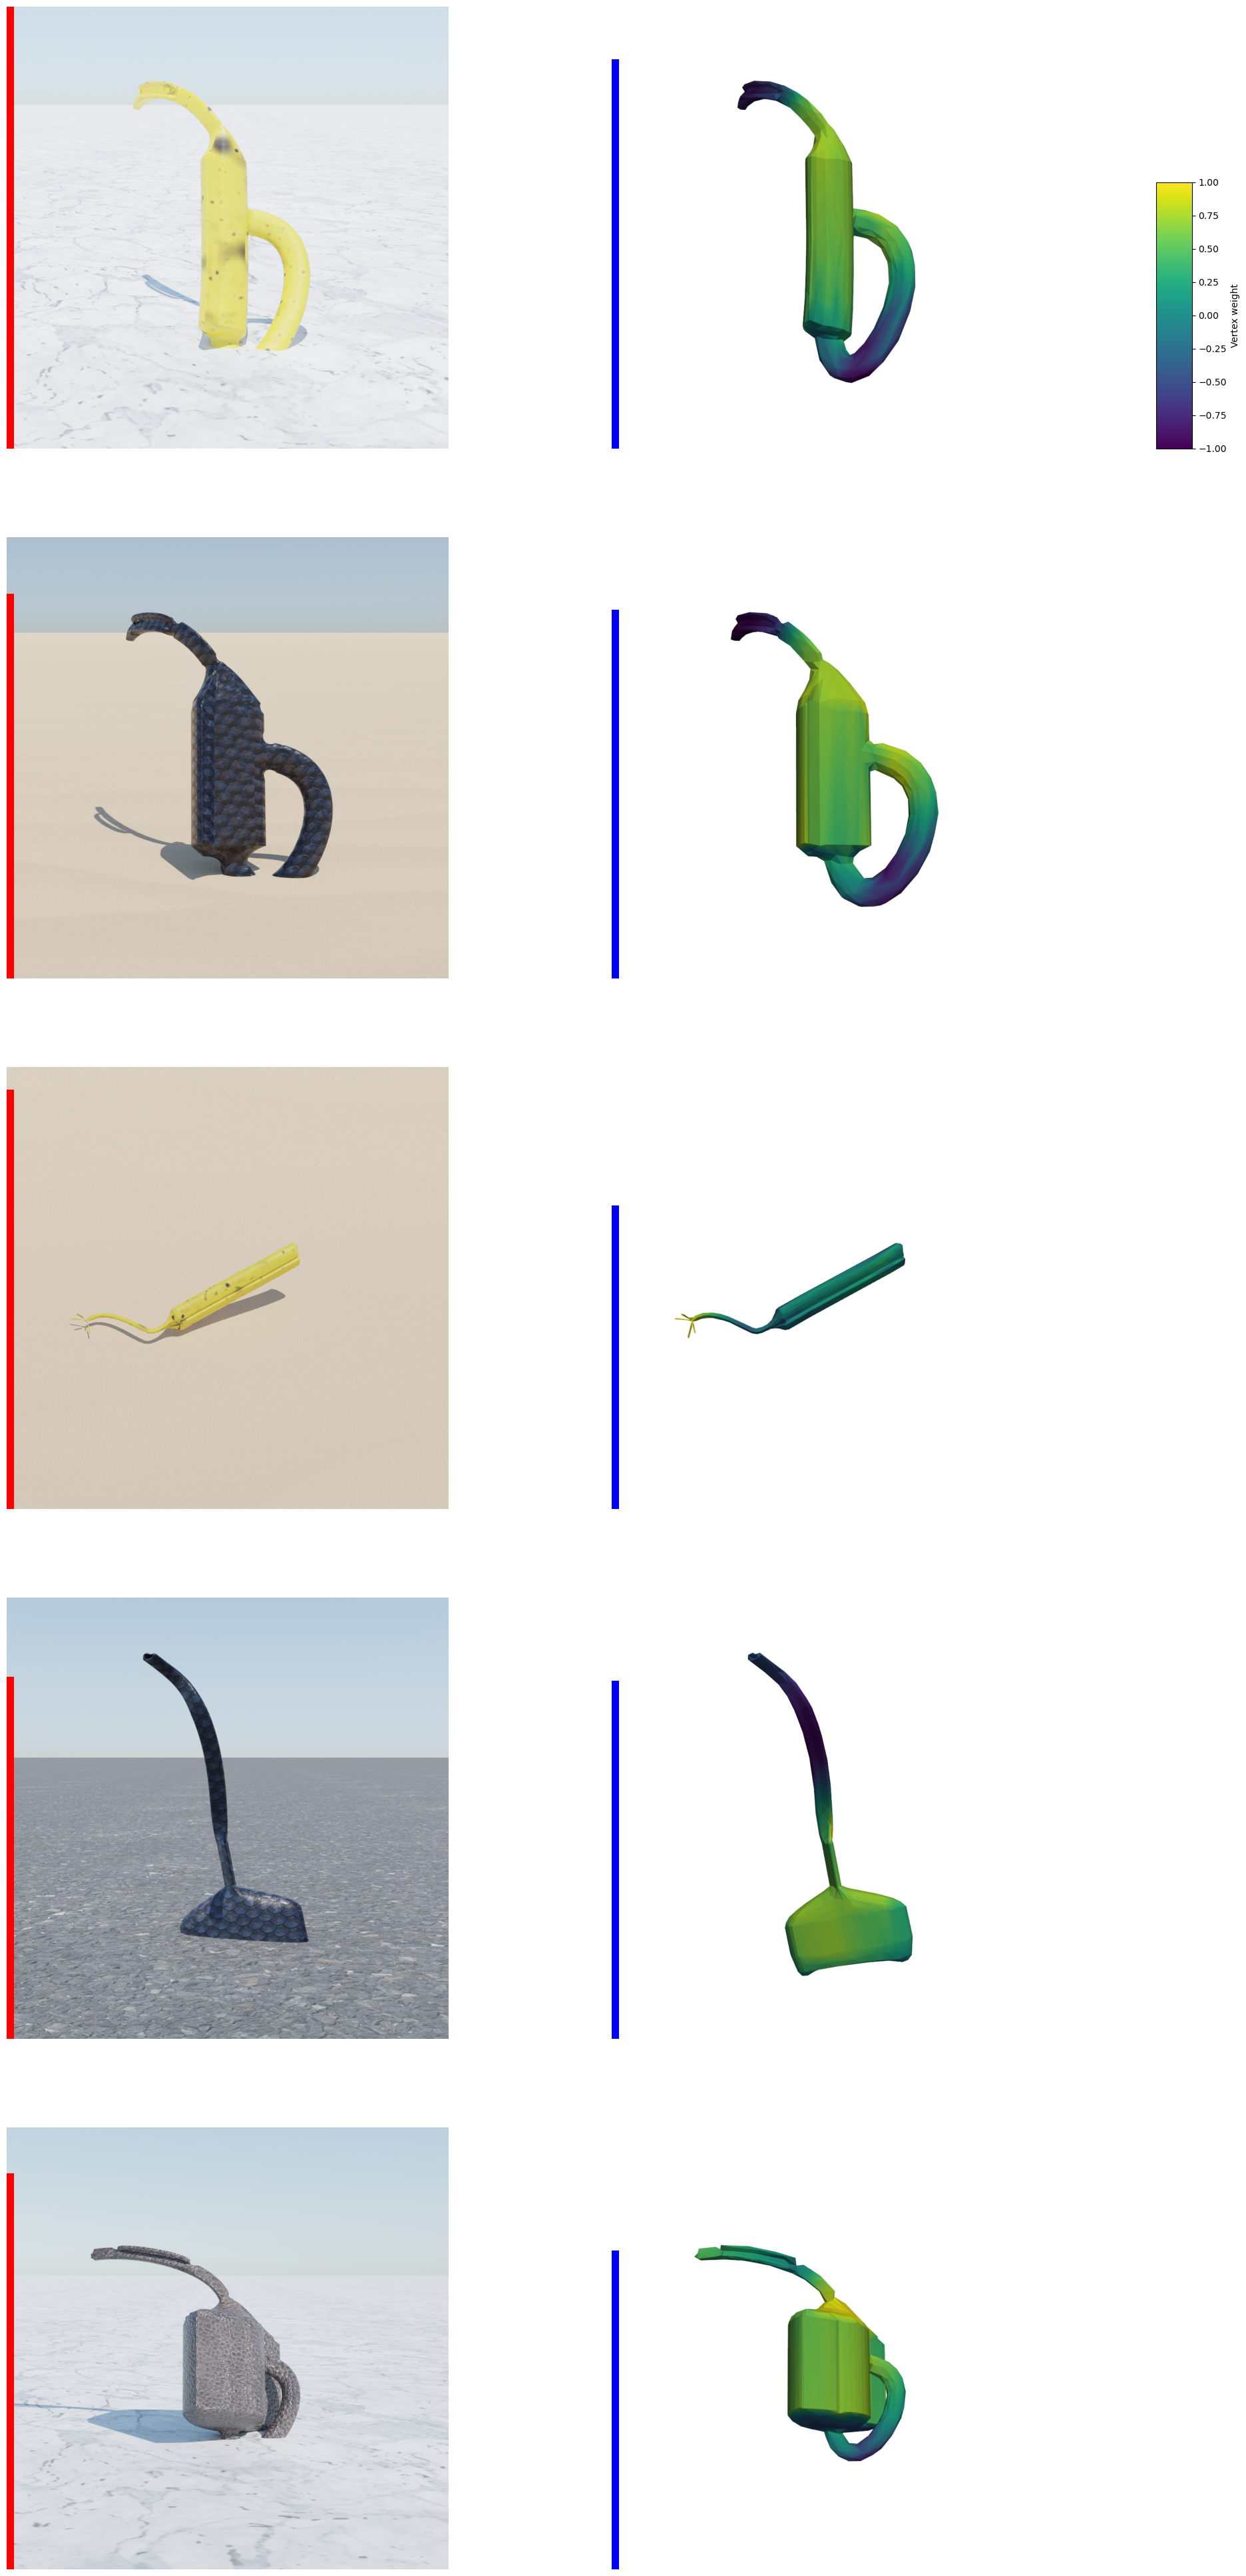

In [138]:
def plot_stim(stim_idx, axs):
    p, mesh, render_img, mesh_img = load_mesh_img(stim_idx, upsample=False, background_color=None)
    r_obs_pred = obs[stim_idx, ch_idx], preds[stim_idx, ch_idx]
    r_obs_pred = np.clip(r_obs_pred, 0, 1) * 1024
   
    for ax, img, r, bar_color in zip(axs, (render_img, mesh_img), r_obs_pred, ('red', 'blue')):
        ax.imshow(img)
        ax.axis('off')
        rect = mpl.patches.Rectangle((0, 1024 - r), 16, r, facecolor=bar_color)
        ax.add_patch(rect)

expt.model.outputs_at = 'vertices'
ch_idx = 4
avg_response = (obs[:, ch_idx] + preds[:, ch_idx]) / 2
n_stim = 5
best_stim_idxs = np.argsort(avg_response)[-n_stim:][::-1]
stim_idx = best_stim_idxs[0]

fig_w = 10
fig, axs = plt.subplots(n_stim, 2, figsize=(fig_w * 2.15, n_stim * fig_w), squeeze=False)
for stim_idx, axs_i in zip(best_stim_idxs, axs):
    plot_stim(stim_idx, axs_i)

pos = axs[0, 1].get_position()
cax = fig.add_axes([.95, pos.y0, .025, .4 / n_stim])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
cb = plt.colorbar(mappable, cax=cax, label='Vertex weight')